# General Configuration
### Imports all the necessary libraries

In [60]:
%pip install --upgrade pip
%pip install quantstats
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [61]:
import os
import pandas as pd
from datetime import datetime
from operator import itemgetter
import matplotlib.pyplot as plt
import quantstats as qs
import csv

## Data management

In [62]:
def load_csv_files(num_weeks, data_folder='../data/ethereum-tokens', inclusion = 1):
    
    # List all files in the directory
    files = os.listdir(data_folder)
    
    # Filter out files that are not CSV
    files = [f for f in files if f.endswith('.csv')]
    
    # Extract dates from file names and pair them with file names
    files_with_dates = []
    for file in files:
        date_str = file.replace('.csv', '')
        date = datetime.strptime(date_str, '%Y-%m-%d')
        files_with_dates.append((file, date))
    
    # Sort files by date
    sorted_files_with_dates = sorted(files_with_dates, key=itemgetter(1))
    
    # Select every Nth file based on the num_weeks
    selected_files = [file for i, (file, date) in enumerate(sorted_files_with_dates) if i % num_weeks == 0]
    
    # Load selected files
    dfs = []
    token_presence_count = {}
    
    for file in selected_files:
        df = pd.read_csv(os.path.join(data_folder, file), index_col='Rank')
        
        # Count the presence of each token in the top tokens list
        tokens_to_remove = []

        for token_id in df['id']:
            token_presence_count[token_id] = token_presence_count.get(token_id, 0) + 1

        if len(dfs) > 2*inclusion:  # start checking from the n+1th week onwards
            for token_id in df['id']:
                if token_id in token_presence_count:
                    if token_presence_count[token_id] < inclusion:
                        tokens_to_remove.append(token_id)
                else:
                    tokens_to_remove.append(token_id)

        df = df[~df['id'].isin(tokens_to_remove)]
        
        dfs.append(df)

    return dfs

## Helper functions for calculate_index

In [63]:
def compute_divisor(snapshot, target_price=None):
    total_market_cap_0 = snapshot['Market cap'].sum()

    return total_market_cap_0 / target_price

def compute_current_value(snapshot, divisor):
    if divisor == 0:
        return None
    daily_value = snapshot['Market cap'].sum()
    index_value_t = daily_value / divisor
    return index_value_t

In [64]:
def compute_index_history(constituent_number, weeks_interval, initial_index_value = 100, swap_fees = 0, inc = 1):

    source_dfs = load_csv_files(weeks_interval, inclusion = inc)

    folder = f"../data/{weeks_interval}w-ethereum-tokens"

    files = os.listdir(folder)
    
    # Filter out files that are not CSV
    files = [f for f in files if f.endswith('.csv')]
    files = sorted(files)

    shifted_dfs = []

    for file in files:
        df = pd.read_csv(os.path.join(folder, file), index_col='Rank')
        shifted_dfs.append(df)
    
    index_values = [initial_index_value]

    index_value = initial_index_value
    
    # Loop over all the data for backtesting
    for i in range(len(source_dfs)):
        source_df = source_dfs[i][:constituent_number]

        selected_tokens = set(source_df['id'])  # Get the tokens chosen in the source_df

        divisor = compute_divisor(source_df, index_value)
        # print(len(source_df))

        # Get data for all weeks between the rebalancing periods.
        for j in range(weeks_interval):
            if i*weeks_interval+j >= len(shifted_dfs):
                break

            shifted_df = shifted_dfs[i*weeks_interval+j][:constituent_number]

            # Filter the shifted_df to consider only the selected tokens
            shifted_df = shifted_df[shifted_df['id'].isin(selected_tokens)][:constituent_number]
            
            index_value = compute_current_value(shifted_df, divisor)
            if(j == weeks_interval-1):
                index_value -= swap_fees * constituent_number
            index_values.append(index_value)
            
    return index_values[:-1]


### Main calculate_index function

In [65]:
backtest = []

weeks = [1, 2, 4, 8, 12, 24]
constituents = [5, 10, 20, 30]

initial_value = 1
swap_fees = 0
inclusion_weeks = 0

for week in weeks:
    for constituent in constituents:
        backtest.append((compute_index_history(constituent, week, initial_value, swap_fees, inclusion_weeks), week, constituent))

backtest.sort(key=lambda x: x[0][-1], reverse=True)

## Performance analysis

In [66]:
def calculate_risk_free(file_path):
    total_close = 0
    count = 0
    
    with open(file_path, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        
        # Skip the header
        next(csvreader)
        
        for row in csvreader:
            close_price = float(row[4])  # Close price is in the 5th column (index 4)
            total_close += close_price
            count += 1
            
    if count == 0:
        return "No data available"
    
    average_close = total_close / count
    return average_close

In [67]:
risk_free_rate = calculate_risk_free("../data/risk-free.csv")
print(f"Risk-free rate: {risk_free_rate}")

Risk-free rate: 1.5410894736842107


In [68]:
import pandas as pd
import quantstats as qs

# Creating an empty DataFrame to store the results
summary_stats = pd.DataFrame(columns=['Rank', 'Weeks', 'Constituents', 'Total Return', 'Mean Return', 'Median Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown'])

# Iterating through all the backtests to calculate the required statistics
for values, week, constituents in backtest:
    prices_series = pd.Series(values)
    returns = prices_series.pct_change().dropna()

    # Calculating the metrics
    total_return = (prices_series.iloc[-1] / prices_series.iloc[0] - 1) * 100
    mean_return = returns.mean() * 100
    median_return = returns.median() * 100
    std_dev = returns.std() * 100
    sharpe_ratio = qs.stats.sharpe(returns, rf=risk_free_rate)
    sortino_ratio = qs.stats.sortino(returns, rf=risk_free_rate)
    max_drawdown = qs.stats.max_drawdown(returns) * 100

    # Adding the results to the DataFrame
    summary_stats.loc[len(summary_stats)] = [0, int(week), int(constituents), round(total_return, 2), round(mean_return, 2), round(median_return, 2), round(std_dev, 2), round(sharpe_ratio, 2), round(sortino_ratio, 2), round(max_drawdown, 2)]

# Converting 'Weeks' and 'Constituents' to integers
summary_stats['Weeks'] = summary_stats['Weeks'].astype(int)
summary_stats['Constituents'] = summary_stats['Constituents'].astype(int)

# Assigning ranks based on Total Return
summary_stats['Rank'] = summary_stats['Total Return'].rank(ascending=False).astype(int)

# Getting top 5 for different metrics and resetting index to get rank from 1 to 5
top5_total_return = summary_stats.sort_values(by='Total Return', ascending=False).head(5).reset_index(drop=True)
top5_std_dev = summary_stats.sort_values(by='Standard Deviation', ascending=True).head(5).reset_index(drop=True)
top5_sharpe_ratio = summary_stats.sort_values(by='Sharpe Ratio', ascending=False).head(5).reset_index(drop=True)

# Assigning ranks from 1 to 5 for the top 5 dataframes
top5_total_return['Rank'] = top5_total_return.index + 1
top5_std_dev['Rank'] = top5_std_dev.index + 1
top5_sharpe_ratio['Rank'] = top5_sharpe_ratio.index + 1

# Saving the top 5 dataframes to separate CSV files
csv_paths = {
    'total_return': '../results/top5_total_return.csv',
    'std_dev': '../results/top5_std_dev.csv',
    'sharpe_ratio': '../results/top5_sharpe_ratio.csv',
    'summary_stats': '../results/summary_stats.csv'
}

top5_total_return.to_csv(csv_paths['total_return'], index=False)
top5_std_dev.to_csv(csv_paths['std_dev'], index=False)
top5_sharpe_ratio.to_csv(csv_paths['sharpe_ratio'], index=False)
summary_stats.to_csv(csv_paths['summary_stats'], index=False)

# Printing the dataframes
print("Top 5 by Total Return")
print(top5_total_return)
print("\nTop 5 by Standard Deviation")
print(top5_std_dev)
print("\nTop 5 by Sharpe Ratio")
print(top5_sharpe_ratio)
print("\nSummary Statistics")
print(summary_stats)


Top 5 by Total Return
   Rank  Weeks  Constituents  Total Return  Mean Return  Median Return  \
0     1      8            30        556.65         1.99           1.54   
1     2      1            30        536.28         1.96           1.72   
2     3      2            30        510.77         1.93           1.70   
3     4      4            30        506.04         1.95           1.71   
4     5      1            20        464.79         1.90           1.37   

   Standard Deviation  Sharpe Ratio  Sortino Ratio  Max Drawdown  
0               14.02          1.83           2.83        -84.11  
1               13.83          1.82           2.76        -83.04  
2               13.79          1.79           2.72        -83.03  
3               14.02          1.79           2.74        -83.81  
4               13.89          1.75           2.65        -82.63  

Top 5 by Standard Deviation
    Rank  Weeks  Constituents  Total Return  Mean Return  Median Return  \
2      3      2            

Legend:
Week 8, Constituents: 30, Color: Green (#008000)
Week 1, Constituents: 30, Color: Orange (#FFA500)
Week 2, Constituents: 30, Color: Blue (#0000FF)
Week 4, Constituents: 30, Color: Red (#FF0000)
Week 1, Constituents: 20, Color: Purple (#800080)


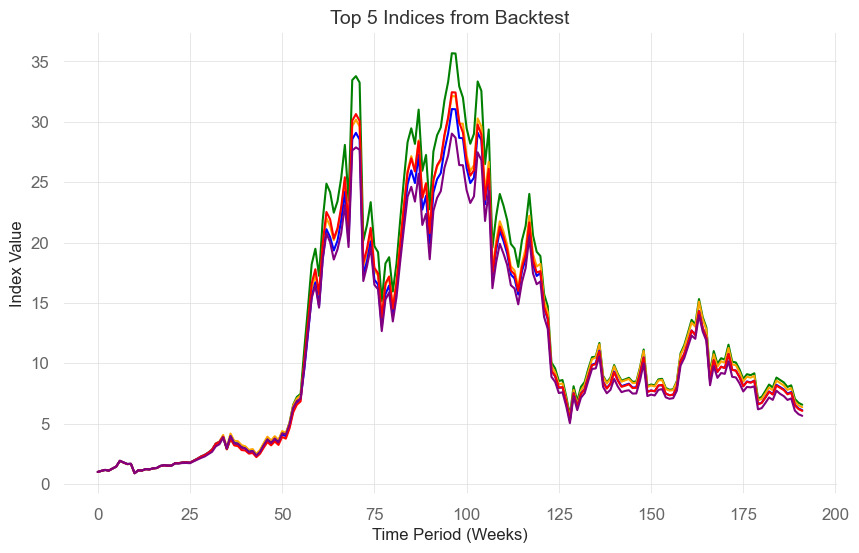

In [69]:
top_backtests = backtest[:5]  # Get the top 5 backtests

colors = [
    ("Green", '#008000'), 
    ("Orange", '#FFA500'), 
    ("Blue", '#0000FF'), 
    ("Red", '#FF0000'), 
    ("Purple", '#800080')
]

plt.figure(figsize=(10, 6))

print("Legend:")
for i, (values, week, constituents) in enumerate(top_backtests):
    plt.plot(values, color=colors[i][1])
    print(f"Week {week}, Constituents: {constituents}, Color: {colors[i][0]} ({colors[i][1]})")

plt.xlabel('Time Period (Weeks)', fontsize=12)
plt.ylabel('Index Value', fontsize=12)
plt.title('Top 5 Indices from Backtest', fontsize=14)
plt.grid(True)

# Save the plot as a high-resolution PNG file
plt.savefig('../results/top_5_indices_backtest.png', dpi=300)

plt.show()

In [70]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming 'Total Return' is one of the performance metrics in summary_stats
# 'Weeks' and 'Constituents' are the configurations you're testing

anova_model = ols('summary_stats["Total Return"] ~ C(summary_stats["Weeks"]) + C(summary_stats["Constituents"])', data=summary_stats).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)


                                         sum_sq    df          F        PR(>F)
C(summary_stats["Weeks"])         119432.817321   5.0  16.907228  1.076133e-05
C(summary_stats["Constituents"])  249293.235879   3.0  58.817693  1.586494e-08
Residual                           21192.027796  15.0        NaN           NaN


In [71]:
# Multivariate Regression model
multi_reg_model = ols('summary_stats["Total Return"] ~ summary_stats["Weeks"] + summary_stats["Constituents"] + summary_stats["Weeks"]:summary_stats["Constituents"]', data=summary_stats).fit()

# Summary of the regression model to see coefficients, R-squared, and other stats
print(multi_reg_model.summary())


                                  OLS Regression Results                                 
Dep. Variable:     summary_stats["Total Return"]   R-squared:                       0.778
Model:                                       OLS   Adj. R-squared:                  0.745
Method:                            Least Squares   F-statistic:                     23.35
Date:                           Sat, 09 Sep 2023   Prob (F-statistic):           9.66e-07
Time:                                   19:20:24   Log-Likelihood:                -132.35
No. Observations:                             24   AIC:                             272.7
Df Residuals:                                 20   BIC:                             277.4
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
                                                           coef    std err          t      P>|t|    